# Problem Statement

The objective of this competition is to predict the probability that a customer does not pay back their credit card balance amount in the future based on their monthly customer profile. The target binary variable is calculated by observing 18 months performance window after the latest credit card statement, and if the customer does not pay due amount in 120 days after their latest statement date it is considered a default event.

The dataset contains aggregated profile features for each customer at each statement date. Features are anonymized and normalized, and fall into the following general categories:

- D_* = Delinquency variables
- S_* = Spend variables
- P_* = Payment variables
- B_* = Balance variables
- R_* = Risk variables

With the following features being categorical:

['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']

Our task is to predict, for each customer_ID, the probability of a future payment default (target = 1).

Note that the negative class has been subsampled for this dataset at 5%, and thus receives a 20x weighting in the scoring metric.

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Filtering the Large Dataset

In [38]:
# Chunk = pd.read_csv("train_data.csv",chunksize=100000)
# Train = pd.concat(Chunk)
# Train_labels = pd.read_csv("train_labels.csv")

# Train = pd.merge(Train,Train_labels,how="inner",on=["customer_ID"])

# Train = Train.head(200000)
# Train.to_csv("Train.csv",index=False)

# Test = pd.read_csv("test_data.csv",chunksize=100000)
# Test = pd.concat(Test)
# Test = Test.head(500000)
# Test.to_csv("Test.csv",index = False)

In [39]:
Train = pd.read_csv("Train.csv")
Test = pd.read_csv("Test.csv")

In [40]:
Test.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,2019-02-19,0.631315,0.001912,0.010728,0.814497,0.007547,0.168651,0.009971,0.002347,...,NaN,NaN,NaN,NaN,0.004669,NaN,NaN,NaN,0.008281,NaN
1,00000469ba478561f23a92a868bd366de6f6527a684c9a...,2019-03-25,0.587042,0.005275,0.011026,0.810848,0.001817,0.241389,0.000166,0.009132,...,NaN,NaN,NaN,0.000142,0.004940,0.009021,NaN,0.003695,0.003753,0.001460
2,00000469ba478561f23a92a868bd366de6f6527a684c9a...,2019-04-25,0.609056,0.003326,0.016390,1.004620,0.000114,0.266976,0.004196,0.004192,...,NaN,NaN,NaN,0.000074,0.002114,0.004656,NaN,0.003155,0.002156,0.006482
3,00000469ba478561f23a92a868bd366de6f6527a684c9a...,2019-05-20,0.614911,0.009065,0.021672,0.816549,0.009722,0.188947,0.004123,0.015325,...,NaN,NaN,NaN,0.004743,0.006392,0.002890,NaN,0.006044,0.005206,0.007855
4,00000469ba478561f23a92a868bd366de6f6527a684c9a...,2019-06-15,0.591673,0.238794,0.015923,0.810456,0.002026,0.180035,0.000731,0.011281,...,NaN,NaN,NaN,0.008133,0.004329,0.008384,NaN,0.001008,0.007421,0.009471


In [41]:
Train.nunique()

customer_ID     16576
S_2               396
P_2            198458
D_39           200000
B_1            200000
                ...  
D_142           34356
D_143          196497
D_144          198567
D_145          196497
target              2
Length: 191, dtype: int64

In [42]:
Train.describe()

,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,D_43,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
count,198458.000000,2.000000e+05,200000.000000,199928.000000,2.000000e+05,162335.000000,1.999280e+05,1.999280e+05,29193.000000,1.399420e+05,...,7.186000e+03,7186.000000,1.964970e+05,1.985810e+05,1.964970e+05,34356.000000,1.964970e+05,1.985670e+05,1.964970e+05,200000.000000
mean,0.653527,1.534126e-01,0.125356,0.616971,8.121541e-02,0.227386,6.221769e-02,1.343925e-01,0.181170,1.560354e-01,...,1.424359e-02,0.162349,1.798358e-01,2.622542e-02,1.653822e-01,0.392596,1.797362e-01,5.339187e-02,6.179908e-02,0.253395
std,0.246135,2.723813e-01,0.213396,0.402275,2.309947e-01,0.197101,2.081621e-01,2.348492e-01,0.216851,2.169740e-01,...,9.543979e-02,0.258647,3.798505e-01,1.441568e-01,3.490555e-01,0.238923,3.797464e-01,1.851044e-01,1.901802e-01,0.434956
min,-0.383019,3.892609e-07,-0.899396,0.000003,2.962930e-08,-0.254707,5.627163e-08,1.042180e-07,-0.000219,8.705647e-07,...,4.129697e-08,0.000002,7.139375e-08,5.277736e-08,5.642931e-08,-0.014441,1.653580e-08,1.161969e-07,3.397747e-08,0.000000
25%,0.476334,4.541390e-03,0.008858,0.100550,2.899612e-03,0.127432,2.897833e-03,5.290730e-03,0.039449,4.235285e-02,...,2.589397e-03,0.003541,3.018427e-03,2.551375e-03,3.033245e-03,0.196174,3.034162e-03,2.752575e-03,3.027842e-03,0.000000
50%,0.691541,9.066380e-03,0.031935,0.814164,5.792558e-03,0.164248,5.768750e-03,9.872834e-03,0.120749,8.828850e-02,...,5.141117e-03,0.007028,6.041458e-03,5.109293e-03,6.062756e-03,0.382038,6.077791e-03,5.499113e-03,6.059988e-03,0.000000
75%,0.863455,2.360171e-01,0.129569,1.002240,8.684554e-03,0.260202,8.652639e-03,1.635911e-01,0.250728,1.850985e-01,...,7.667529e-03,0.501621,9.096570e-03,7.658175e-03,9.094362e-03,0.566102,9.088631e-03,8.267479e-03,9.093526e-03,1.000000
max,1.009998,5.331360e+00,1.324053,1.010000,2.507711e+00,2.918675,6.798167e+00,1.625262e+00,3.252056,9.089694e+00,...,1.009913e+00,1.509486,1.010000e+00,1.009994e+00,1.174753e+00,1.751388,1.010000e+00,1.343284e+00,4.282032e+00,1.000000


In [43]:
print(Train.isnull().sum())

customer_ID         0
S_2                 0
P_2              1542
D_39                0
B_1                 0
                ...  
D_142          165644
D_143            3503
D_144            1433
D_145            3503
target              0
Length: 191, dtype: int64


In [44]:
Categorical_Features = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']

for features in Categorical_Features:
    print(Train[features].unique())
    print(Train[features].value_counts())
    

[ 0.  2.  1. nan]
0.0    169651
1.0     28195
2.0      2082
Name: B_30, dtype: int64
[ 2.  1.  3.  5.  6.  7.  4. nan]
2.0    69185
3.0    45557
1.0    42290
5.0    16264
4.0    10948
7.0     9821
6.0     5863
Name: B_38, dtype: int64
[ 1.  0. nan]
1.0    119921
0.0     73734
Name: D_114, dtype: int64
[ 0. nan  1.]
0.0    193429
1.0       226
Name: D_116, dtype: int64
[ 4. -1.  6.  2.  1. nan  3.  5.]
-1.0    52208
 3.0    41808
 4.0    41322
 2.0    24095
 5.0    17049
 6.0    12774
 1.0     4399
Name: D_117, dtype: int64
[ 0.  1. nan]
0.0    170250
1.0     23405
Name: D_120, dtype: int64
[ 1. nan  0. -1.]
 1.0    154085
 0.0     32515
-1.0      9175
Name: D_126, dtype: int64
['CR' 'CO' 'CL' 'XZ' 'XM' 'XL']
CO    148773
CR     33751
CL     15991
XZ       925
XM       309
XL       251
Name: D_63, dtype: int64
['O' 'R' nan 'U' '-1']
O     105870
U      55177
R      29601
-1      1312
Name: D_64, dtype: int64
[nan  1.  0.]
1.0    21951
0.0      229
Name: D_66, dtype: int64
[ 6.  2.  3. n

In [45]:
# Selecting only the recent transactions of a customer for processing  
Train = Train.groupby('customer_ID').tail(1).set_index('customer_ID')

# Counting different Variables
Delinquency_Variable = [variable for variable in Train.columns if variable.startswith('D_')]
Spend_Variable = [variable for variable in Train.columns if variable.startswith('S_')]
Payment_Variable = [variable for variable in Train.columns if variable.startswith('P_')]
Balance_Variable = [variable for variable in Train.columns if variable.startswith('B_')]
Risk_Variable = [variable for variable in Train.columns if variable.startswith('R_')]
print(f'Total number of Delinquency variables: {len(Delinquency_Variable)}')
print(f'Total number of Spend variables: {len(Spend_Variable)}')
print(f'Total number of Payment variables: {len(Payment_Variable)}')
print(f'Total number of Balance variables: {len(Balance_Variable)}')
print(f'Total number of Risk variables: {len(Risk_Variable)}')

Total number of Delinquency variables: 96
Total number of Spend variables: 22
Total number of Payment variables: 3
Total number of Balance variables: 40
Total number of Risk variables: 28


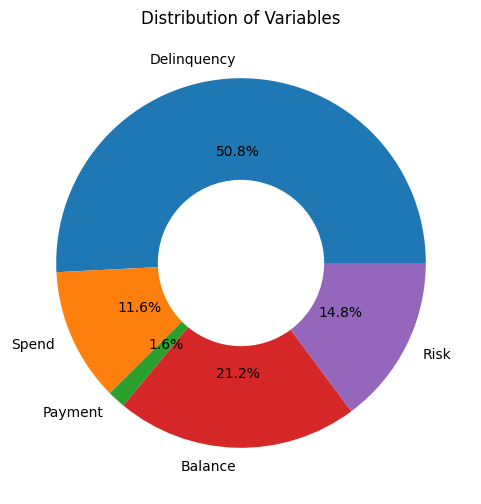

In [46]:
values = [len(Delinquency_Variable),len(Spend_Variable),len(Payment_Variable),len(Balance_Variable),len(Risk_Variable)]
labels = ['Delinquency', 'Spend','Payment','Balance','Risk']

plt.figure(figsize=(6, 6))
plt.pie(values, labels=labels, autopct='%1.1f%%',wedgeprops=dict(width=0.55))
plt.title('Distribution of Variables')
plt.show()

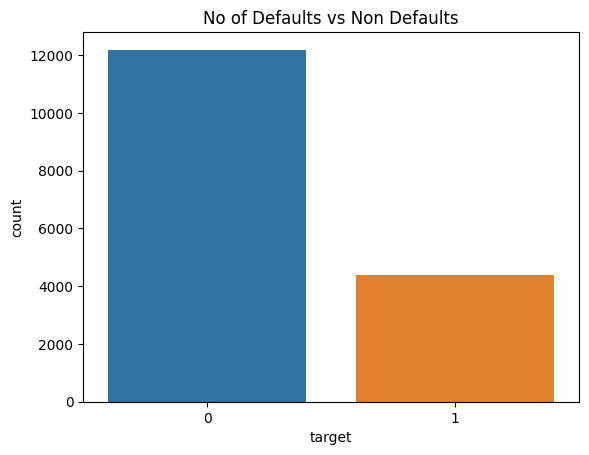

In [47]:
# plt.figure(figsize=(15,6))
sns.countplot(x='target', data = Train)
plt.title("No of Defaults vs Non Defaults")
plt.show()

Text(0.5, 1.0, 'Percentage share of Defaults')

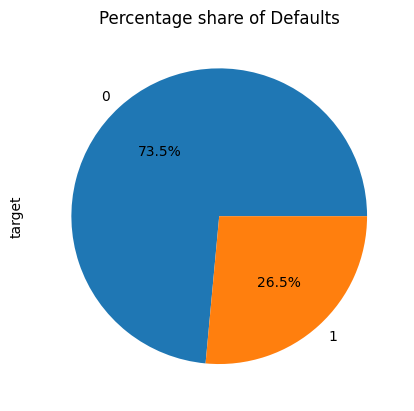

In [48]:
Train['target'].value_counts().plot(kind = 'pie',autopct='%1.1f%%')
plt.title("Percentage share of Defaults")

In [49]:
for features in Categorical_Features:
    print(Train[features].unique())
    print(Train[features].value_counts())

[ 0.  1.  2. nan]
0.0    13787
1.0     2607
2.0      181
Name: B_30, dtype: int64
[ 2.  1.  3.  7.  5.  6.  4. nan]
2.0    5410
3.0    3753
1.0    3444
5.0    1437
7.0    1000
4.0     976
6.0     555
Name: B_38, dtype: int64
[ 1.  0. nan]
1.0    10084
0.0     6282
Name: D_114, dtype: int64
[ 0. nan  1.]
0.0    16322
1.0       44
Name: D_116, dtype: int64
[ 4. -1.  6.  1.  2.  5.  3. nan]
-1.0    4459
 4.0    3484
 3.0    3448
 2.0    2013
 5.0    1488
 6.0    1128
 1.0     346
Name: D_117, dtype: int64
[ 0.  1. nan]
0.0    13167
1.0     3199
Name: D_120, dtype: int64
[1. 0.]
1.0    12826
0.0     3750
Name: D_126, dtype: int64
['CR' 'CO' 'CL' 'XL' 'XZ' 'XM']
CO    12443
CR     2659
CL     1278
XZ      115
XM       44
XL       37
Name: D_63, dtype: int64
['O' 'R' 'U' nan]
O    8850
U    4832
R    2525
Name: D_64, dtype: int64
[nan  1.]
1.0    1882
Name: D_66, dtype: int64
[ 6.  3.  5.  4.  2.  1. nan]
6.0    8302
5.0    3835
3.0    1526
4.0    1487
2.0     779
1.0     317
Name: D_68, dty

In [50]:
from sklearn.preprocessing import LabelEncoder
lab_enc = LabelEncoder()
for cat_feat in Categorical_Features:
    Train[cat_feat] = lab_enc.fit_transform(Train[cat_feat])

In [51]:
for features in Categorical_Features:
    print(Train[features].unique())
    print(Train[features].value_counts())

[0 1 2 3]
0    13787
1     2607
2      181
3        1
Name: B_30, dtype: int64
[1 0 2 6 4 5 3 7]
1    5410
2    3753
0    3444
4    1437
6    1000
3     976
5     555
7       1
Name: B_38, dtype: int64
[1 0 2]
1    10084
0     6282
2      210
Name: D_114, dtype: int64
[0 2 1]
0    16322
2      210
1       44
Name: D_116, dtype: int64
[4 0 6 1 2 5 3 7]
0    4459
4    3484
3    3448
2    2013
5    1488
6    1128
1     346
7     210
Name: D_117, dtype: int64
[0 1 2]
0    13167
1     3199
2      210
Name: D_120, dtype: int64
[1 0]
1    12826
0     3750
Name: D_126, dtype: int64
[2 1 0 3 5 4]
1    12443
2     2659
0     1278
5      115
4       44
3       37
Name: D_63, dtype: int64
[0 1 2 3]
0    8850
2    4832
1    2525
3     369
Name: D_64, dtype: int64
[1 0]
1    14694
0     1882
Name: D_66, dtype: int64
[5 2 4 3 1 0 6]
5    8302
4    3835
2    1526
3    1487
1     779
6     330
0     317
Name: D_68, dtype: int64


In [61]:
Train.head()

,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
customer_ID,,,,,,,,,,,,,,,,,,,,,
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,2018-03-13,0.934745,0.009119,0.009382,1.007647,0.006104,0.135021,0.001604,0.007174,NaN,...,NaN,NaN,0.007186,0.004234,0.005086,NaN,0.005810,0.002970,0.008533,0
00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5,2018-03-25,0.880519,0.178126,0.034684,1.004028,0.006911,0.165509,0.005552,0.005068,NaN,...,NaN,NaN,0.002980,0.007479,0.007870,NaN,0.003284,0.003169,0.008514,0
00001b22f846c82c51f6e3958ccd81970162bae8b007e80662ef27519fcc18c1,2018-03-12,0.880875,0.009704,0.004284,0.812650,0.006450,NaN,0.003796,0.007196,NaN,...,NaN,NaN,0.007383,0.006623,0.000964,NaN,0.002202,0.000834,0.003444,0
000041bdba6ecadd89a52d11886e8eaaec9325906c9723355abb5ca523658edc,2018-03-29,0.621776,0.001083,0.012564,1.006183,0.007829,0.287766,0.004532,0.009937,NaN,...,NaN,NaN,0.002704,0.006184,0.001899,NaN,0.008183,0.005560,0.002983,0
00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8ad51ca8b8c4a24cefed,2018-03-30,0.871900,0.005573,0.007679,0.815746,0.001247,NaN,0.000231,0.005528,NaN,...,NaN,NaN,0.002974,0.004162,0.005764,NaN,0.008154,0.006944,0.000905,0


In [62]:
Train = Train.drop('S_2',axis=1)
X_Train = Train.drop('target', axis=1)
Y_Train = Train['target']

from sklearn.model_selection import train_test_split

# creating dataset split for prediction
X_train, X_test , y_train , y_test = train_test_split(X_Train,Y_Train,test_size=0.2,random_state=42) # 80-20 split

In [63]:
import warnings
warnings.filterwarnings("ignore")

In [64]:
from catboost import CatBoostClassifier
clf = CatBoostClassifier(iterations = 3000, random_state = 42)
clf.fit(X_train, y_train, eval_set = [(X_test, y_test)], cat_features=Categorical_Features,  verbose = 100)


Learning rate set to 0.037207
0:	learn: 0.6544311	test: 0.6549397	best: 0.6549397 (0)	total: 435ms	remaining: 21m 43s
100:	learn: 0.2280403	test: 0.2507311	best: 0.2507311 (100)	total: 14.3s	remaining: 6m 51s
200:	learn: 0.2026208	test: 0.2433350	best: 0.2433206 (199)	total: 26.5s	remaining: 6m 9s
300:	learn: 0.1832475	test: 0.2404938	best: 0.2404938 (300)	total: 39.1s	remaining: 5m 50s
400:	learn: 0.1643315	test: 0.2400258	best: 0.2398588 (367)	total: 52.8s	remaining: 5m 41s
500:	learn: 0.1485042	test: 0.2392565	best: 0.2391489 (489)	total: 1m 6s	remaining: 5m 32s
600:	learn: 0.1335790	test: 0.2389479	best: 0.2387805 (589)	total: 1m 24s	remaining: 5m 36s
700:	learn: 0.1203103	test: 0.2397433	best: 0.2387805 (589)	total: 1m 43s	remaining: 5m 40s
800:	learn: 0.1094683	test: 0.2399599	best: 0.2387805 (589)	total: 2m 2s	remaining: 5m 35s
900:	learn: 0.0997237	test: 0.2404169	best: 0.2387805 (589)	total: 2m 24s	remaining: 5m 35s
1000:	learn: 0.0910599	test: 0.2405846	best: 0.2387805 (589)	

Test Accuracy = 0.8914354644149578
[[2283  181]
 [ 179  673]]


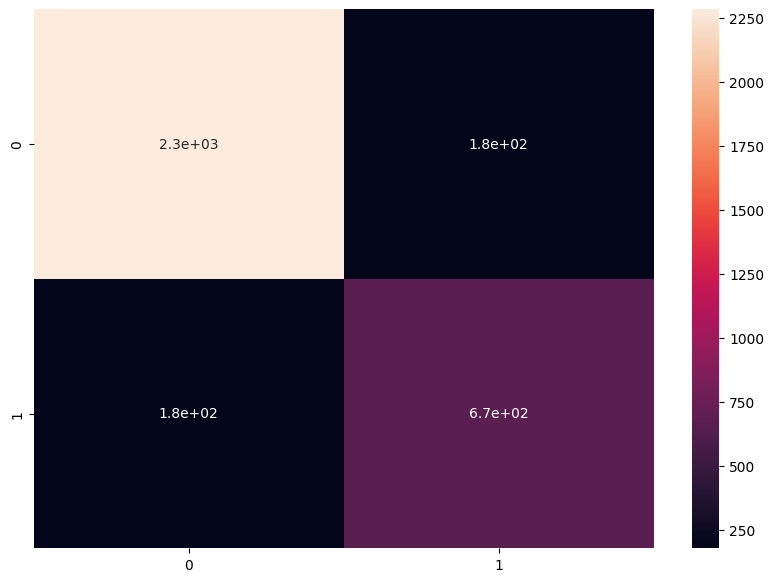

              precision    recall  f1-score   support

           0       0.93      0.93      0.93      2464
           1       0.79      0.79      0.79       852

    accuracy                           0.89      3316
   macro avg       0.86      0.86      0.86      3316
weighted avg       0.89      0.89      0.89      3316



In [65]:
y_pred = clf.predict(X_test)
from sklearn.metrics import accuracy_score
print("Test Accuracy =", accuracy_score(y_test, y_pred))

from sklearn.metrics import confusion_matrix  
print(confusion_matrix(y_test, y_pred))

plt.figure(figsize=[10,7],)
sns.heatmap(confusion_matrix(y_test, y_pred), annot = True)
plt.show()

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))


In [74]:
Train = Train.drop(Train.columns[Train.isnull().mean() >= 0.8], axis=1)
Train = Train.fillna(0)

X_Train = Train.drop('target', axis=1)
Y_Train = Train['target']

X_train, X_test , y_train , y_test = train_test_split(X_Train,Y_Train,test_size=0.2,random_state=42) # 80-20 split

Test Accuracy = 0.8308202653799759
[[2169  295]
 [ 266  586]]


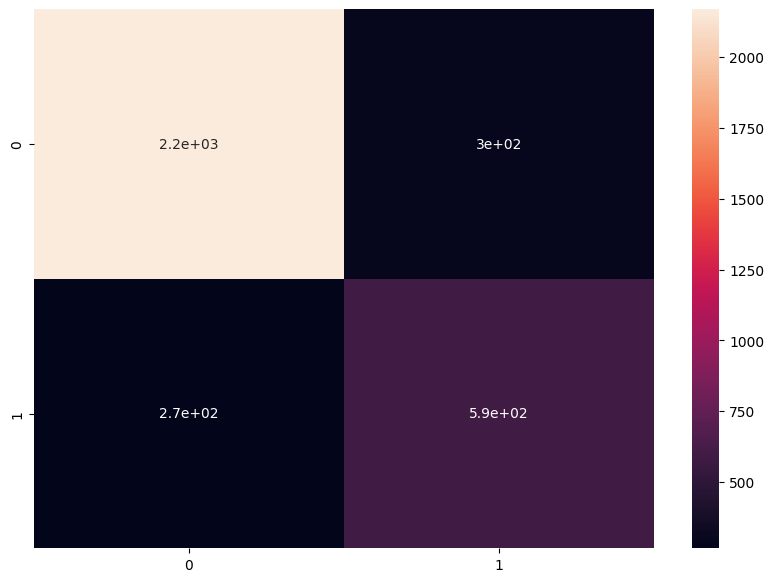

              precision    recall  f1-score   support

           0       0.89      0.88      0.89      2464
           1       0.67      0.69      0.68       852

    accuracy                           0.83      3316
   macro avg       0.78      0.78      0.78      3316
weighted avg       0.83      0.83      0.83      3316



In [75]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Test Accuracy =", accuracy_score(y_test, y_pred))

print(confusion_matrix(y_test, y_pred))

plt.figure(figsize=[10,7],)
sns.heatmap(confusion_matrix(y_test, y_pred), annot = True)
plt.show()

print(classification_report(y_test, y_pred))


Test Accuracy = 0.8841978287092883
[[2279  185]
 [ 199  653]]


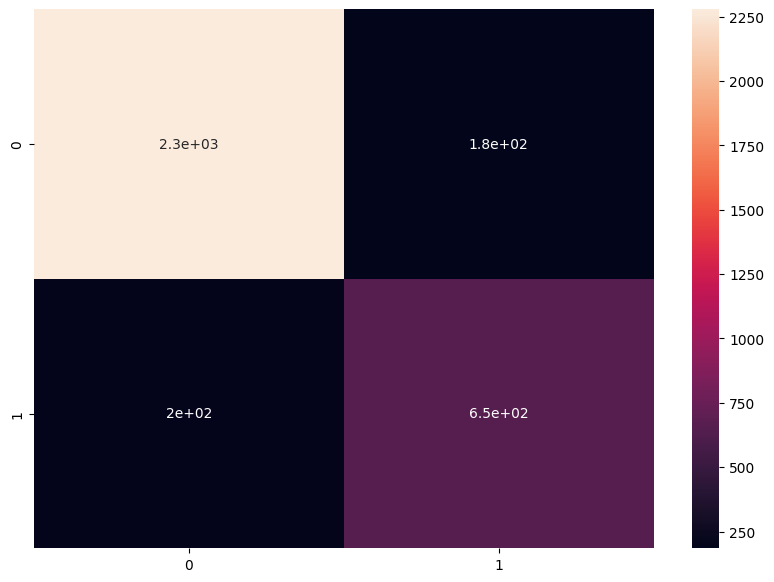

              precision    recall  f1-score   support

           0       0.92      0.92      0.92      2464
           1       0.78      0.77      0.77       852

    accuracy                           0.88      3316
   macro avg       0.85      0.85      0.85      3316
weighted avg       0.88      0.88      0.88      3316



In [76]:
import xgboost as xgb

model = xgb.XGBClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Test Accuracy =", accuracy_score(y_test, y_pred))

print(confusion_matrix(y_test, y_pred))

plt.figure(figsize=[10,7],)
sns.heatmap(confusion_matrix(y_test, y_pred), annot = True)
plt.show()

print(classification_report(y_test, y_pred))